In [99]:
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types
from pyspark.sql import DataFrame

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [79]:
findspark.init()

spark: SparkSession = SparkSession.builder \
    .appName("JupyterLocalSpark") \
    .master("local[*]") \
    .getOrCreate()

In [80]:
df = spark.read \
    .options(header=True, inferSchema=True) \
    .csv("data/m4-stars.csv")

df.printSchema()
print("Rows number", df.count())

root
 |-- source_id: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- parallax_error: double (nullable = true)
 |-- phot_g_mean_mag: double (nullable = true)
 |-- bp_rp: double (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- radial_velocity: double (nullable = true)
 |-- target_separation: double (nullable = true)

Rows number 240958


In [81]:
null_count_df = df.select(
    [
        F.sum(F.col(c).isNull().cast("int")).alias(c)
        for c in df.columns
    ]
)
null_count_df.show()

+---------+---+---+--------+--------------+---------------+-----+-----+-----+---------------+-----------------+
|source_id| ra|dec|parallax|parallax_error|phot_g_mean_mag|bp_rp| pmra|pmdec|radial_velocity|target_separation|
+---------+---+---+--------+--------------+---------------+-----+-----+-----+---------------+-----------------+
|        0|  0|  0|   47842|         47842|            480|17209|47842|47842|         237452|                0|
+---------+---+---+--------+--------------+---------------+-----+-----+-----+---------------+-----------------+



In [82]:
df = df.select([
    "ra",
    "dec",
    "parallax",
    "parallax_error",
    "phot_g_mean_mag",
    "bp_rp",
    "target_separation",
    "pmra",
    "pmdec",
])
df = df.dropna()
print("Rows number", df.count())

Rows number 185434


In [83]:
df = df.where(F.col("parallax") > 0)
print("Rows number", df.count())

Rows number 141147


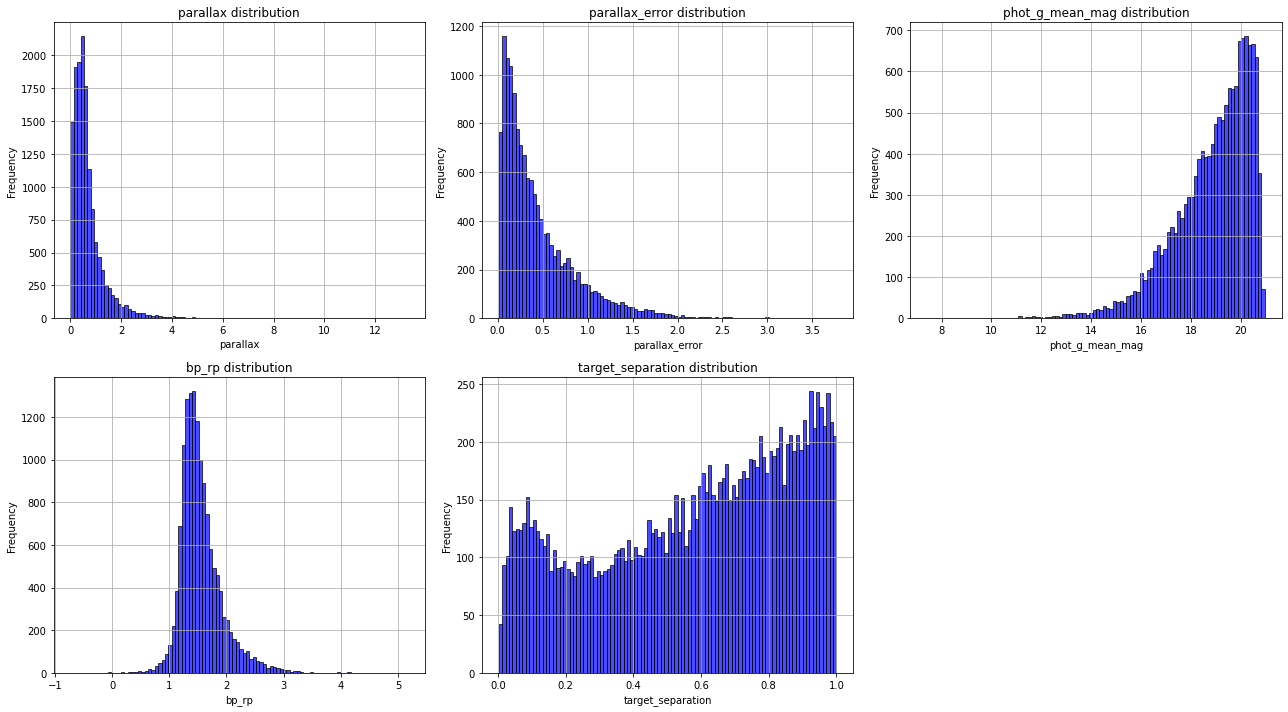

In [84]:
columns = [
    "parallax",
    "parallax_error",
    "phot_g_mean_mag",
    "bp_rp",
    "target_separation",
]
    
df_pd = df \
    .select(columns) \
    .sample(fraction=0.1, seed=42) \
    .toPandas()
    
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(columns):
    df_pd[col].hist(bins=100, alpha=0.7, color="blue", edgecolor="black", ax=axes[i])
    axes[i].set_title(f"{col} distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

In [85]:
df = df.withColumn("distance_ly", 3262 / F.col("parallax"))
df.select("distance_ly").show(5)

+------------------+
|       distance_ly|
+------------------+
| 19667.35320774594|
|3596.1963463889756|
|14864.974785941662|
|10011.010938270552|
| 2213.677958422063|
+------------------+
only showing top 5 rows



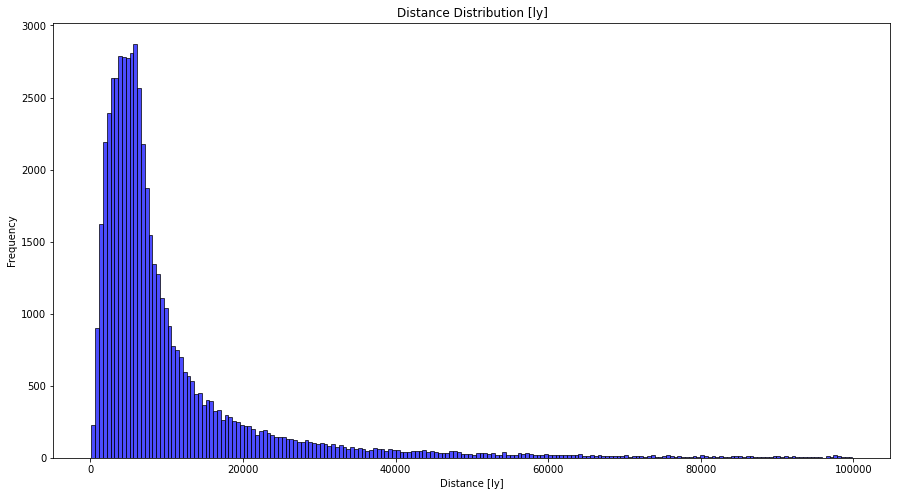

In [86]:
df_pd = df \
    .select("distance_ly") \
    .filter(F.col("distance_ly") < 100_000) \
    .sample(fraction=0.4, seed=42) \
    .toPandas()

plt.figure(figsize=(15, 8))
plt.hist(df_pd["distance_ly"], bins=200, alpha=0.7, color="blue", edgecolor="black")

plt.title("Distance Distribution [ly]")
plt.xlabel("Distance [ly]")
plt.ylabel("Frequency")

plt.show()

In [87]:
df = df.withColumn(
    "distance_error_ly",
    F.abs(
        F.col("distance_ly") - 
        (3262 / (F.col("parallax") + F.col("parallax_error")))
    )
)

df.select("distance_error_ly").show(5)

+------------------+
| distance_error_ly|
+------------------+
|12471.419782091916|
| 832.0822675104173|
| 9307.046666939963|
|5235.3658142385675|
| 846.3640896768727|
+------------------+
only showing top 5 rows



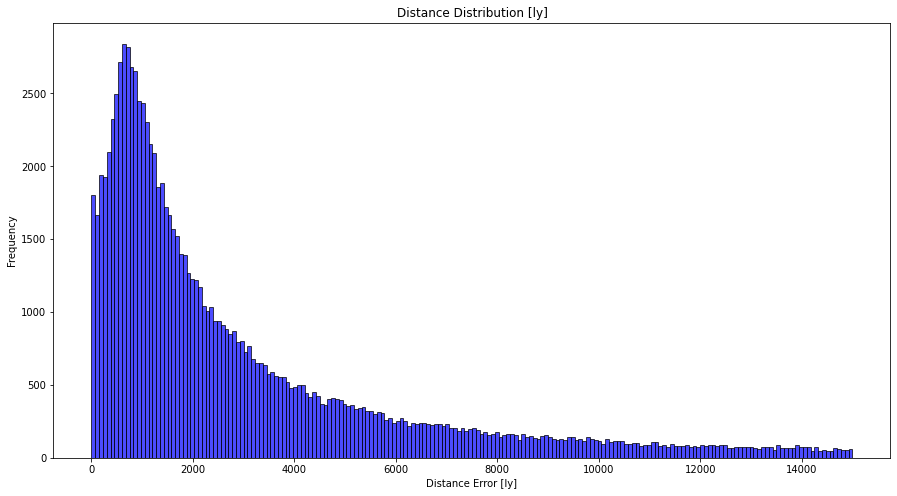

In [88]:
df_pd = df \
    .select("distance_error_ly") \
    .filter(F.col("distance_error_ly") < 15_000) \
    .sample(fraction=0.8, seed=42) \
    .toPandas()

plt.figure(figsize=(15, 8))
plt.hist(df_pd["distance_error_ly"], bins=200, alpha=0.7, color="blue", edgecolor="black")

plt.title("Distance Distribution [ly]")
plt.xlabel("Distance Error [ly]")
plt.ylabel("Frequency")

plt.show()

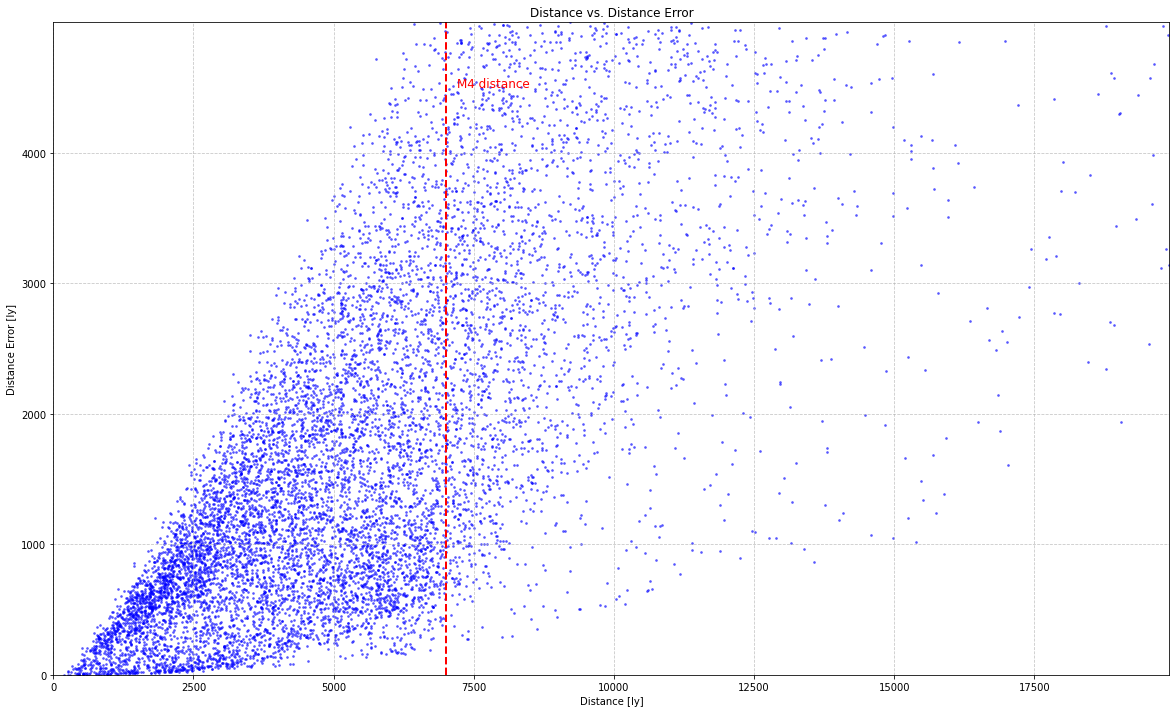

In [89]:
df_pd = df \
    .select("distance_ly", "distance_error_ly") \
    .filter(F.col("distance_error_ly") < 5_000) \
    .filter(F.col("distance_ly") < 20_000) \
    .sample(fraction=0.1, seed=42) \
    .toPandas()
    

plt.figure(figsize=(20, 12))
plt.scatter(df_pd["distance_ly"], df_pd["distance_error_ly"], alpha=0.5, color="blue", s=3)


plt.title("Distance vs. Distance Error")
plt.xlabel("Distance [ly]")
plt.ylabel("Distance Error [ly]")
plt.grid(True, linestyle="--", alpha=0.7)

plt.xlim(0, df_pd["distance_ly"].max())
plt.ylim(0, df_pd["distance_error_ly"].max())



plt.axvline(x=7000, color="red", linestyle="--", linewidth=2, label="M4 distance")
plt.text(7200, df_pd["distance_error_ly"].max() * 0.9, "M4 distance", color="red", fontsize=12)

plt.show()

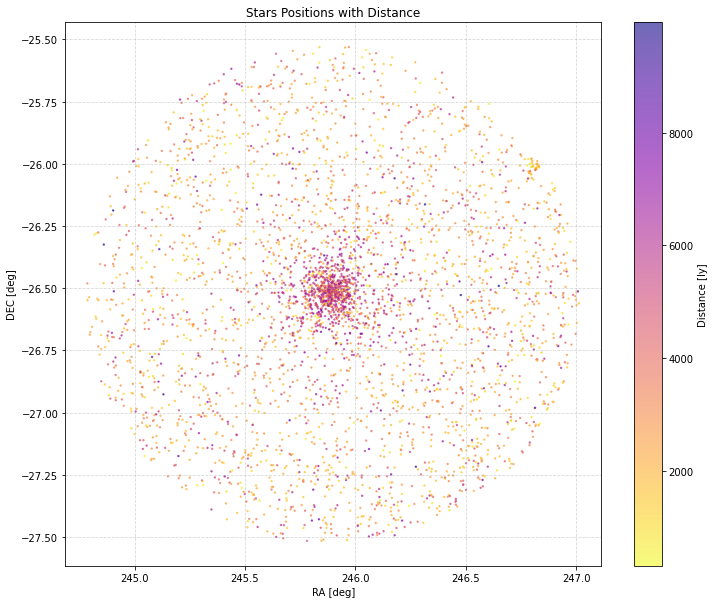

In [90]:
df_pd = df \
    .select("ra", "dec", "distance_ly") \
    .filter(F.col("distance_ly") < 10_000) \
    .filter(F.col("distance_error_ly") < 1000) \
    .sample(fraction=0.1, seed=42) \
    .toPandas()


plt.figure(figsize=(12, 10))

scatter = plt.scatter(df_pd["ra"], df_pd["dec"], c=df_pd["distance_ly"], cmap="plasma_r", alpha=0.6, s=2)

cbar = plt.colorbar(scatter)
cbar.set_label("Distance [ly]")

plt.title("Stars Positions with Distance")
plt.xlabel("RA [deg]")
plt.ylabel("DEC [deg]")
plt.grid(True, linestyle="--", alpha=0.5)

margin = 0.1
plt.xlim(df_pd["ra"].min() - margin, df_pd["ra"].max() + margin)
plt.ylim(df_pd["dec"].min() - margin, df_pd["dec"].max() + margin)

plt.show()

In [117]:
data = df \
    .select("ra", "dec", "pmra", "pmdec", "distance_ly") \
    .filter(F.col("distance_ly") < 10_000) \
    .filter(F.col("distance_error_ly") < 1000) \
    .sample(fraction=0.1, seed=42)

assembler = VectorAssembler(
    inputCols=["ra", "dec", "pmra", "pmdec", "distance_ly"],
    outputCol="features"
)

data_with_features = assembler.transform(data)

kmeans = KMeans().setK(2).setSeed(42).setFeaturesCol("features")
model = kmeans.fit(data_with_features)

In [121]:
clustered_data = model.transform(data_with_features)
final_df = clustered_data.select("ra", "dec", "pmra", "pmdec", "distance_ly", "prediction")
final_df.show(10)

+------------------+-------------------+-------------------+-------------------+------------------+----------+
|                ra|                dec|               pmra|              pmdec|       distance_ly|prediction|
+------------------+-------------------+-------------------+-------------------+------------------+----------+
|245.96581005246324| -26.52135974800348|-12.549003597832026|-18.937513348786275| 6850.826429762299|         1|
| 245.9575105301741|-26.513476732850187|-11.659346460836566| -19.03413616266823|5285.7723025370215|         1|
|245.96193842904506|-26.507456296047856|-12.805471632112743|-19.303218942988195|6659.8826776673895|         1|
| 245.9676914151175|-26.504151477612087|-12.383209495548636|-18.013825498456335| 7600.606992309082|         1|
| 245.9586736583522| -26.50677201991533|-12.272412270741604| -19.79814670378124| 4957.037996736137|         1|
| 245.9534266653701| -26.51214110269624| -12.24437790784932|-19.515110741452983|3797.7872270970247|         0|
|

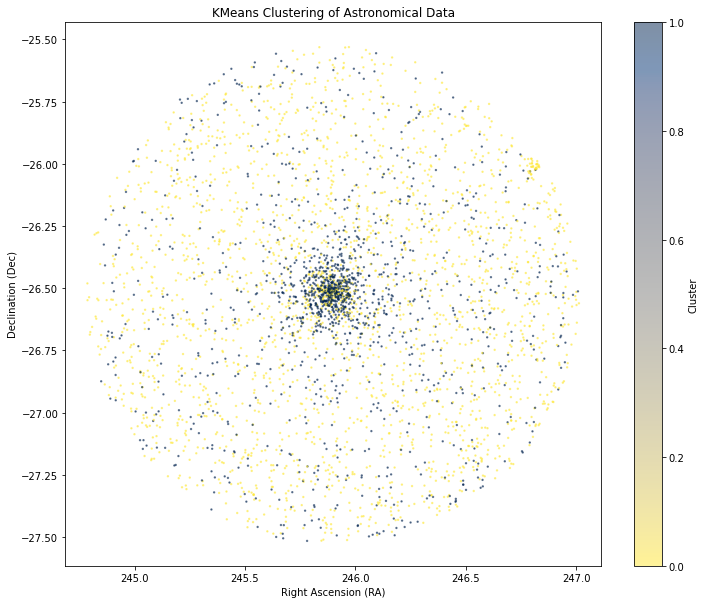

In [125]:
pandas_df = final_df.toPandas()

plt.figure(figsize=(12, 10))
scatter = plt.scatter(pandas_df["ra"], pandas_df["dec"], c=pandas_df["prediction"], cmap="cividis_r", alpha=0.5, s=2)

margin = 0.1
plt.xlim(df_pd["ra"].min() - margin, df_pd["ra"].max() + margin)
plt.ylim(df_pd["dec"].min() - margin, df_pd["dec"].max() + margin)

plt.colorbar(scatter, label="Cluster")

plt.xlabel("Right Ascension (RA)")
plt.ylabel("Declination (Dec)")
plt.title("KMeans Clustering of Astronomical Data")

plt.show()

In [131]:
df = df.withColumn("absolute_mag", F.col("phot_g_mean_mag") - 5 * F.log10(F.col("distance_ly")/3.262) + 5)
df.show(5)

+------------------+-------------------+-------------------+--------------+---------------+---------+------------------+--------------------+-------------------+------------------+------------------+-----------------+
|                ra|                dec|           parallax|parallax_error|phot_g_mean_mag|    bp_rp| target_separation|                pmra|              pmdec|       distance_ly| distance_error_ly|     absolute_mag|
+------------------+-------------------+-------------------+--------------+---------------+---------+------------------+--------------------+-------------------+------------------+------------------+-----------------+
| 245.8420606406876| -27.36044300400829| 0.1658586168430264|    0.28745297|      19.172356|1.5723419|0.8360280711661695|  -8.572431336523547| -6.561640696541579| 19667.35320774594|12471.419782091916|5.271046196587296|
| 245.9060747386242|-27.297972788492366| 0.9070694939322348|    0.27305546|      19.005602|1.2579193|0.7721837534802382|  -4.940

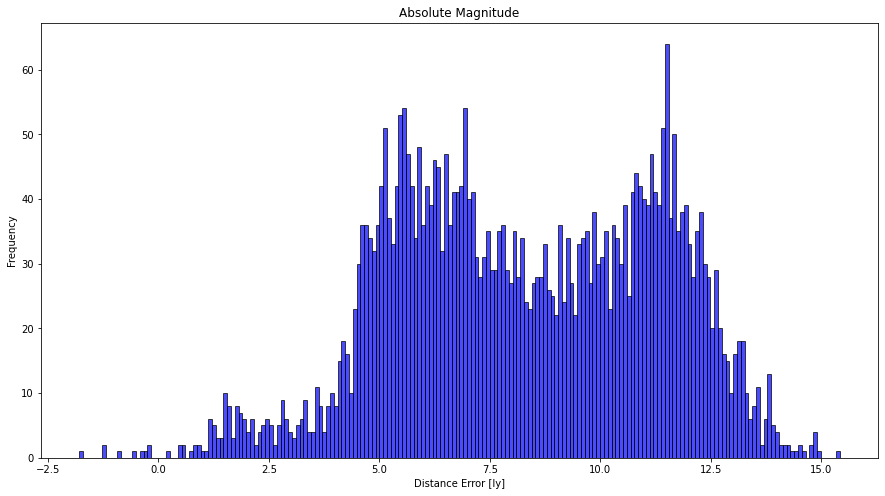

In [132]:
df_pd = df \
    .select("absolute_mag") \
    .where(F.col("distance_error_ly") < 1_000) \
    .sample(fraction=0.1, seed=42) \
    .toPandas()

plt.figure(figsize=(15, 8))
plt.hist(df_pd["absolute_mag"], bins=200, alpha=0.7, color="blue", edgecolor="black")

plt.title("Absolute Magnitude")
plt.xlabel("Distance Error [ly]")
plt.ylabel("Frequency")

plt.show()

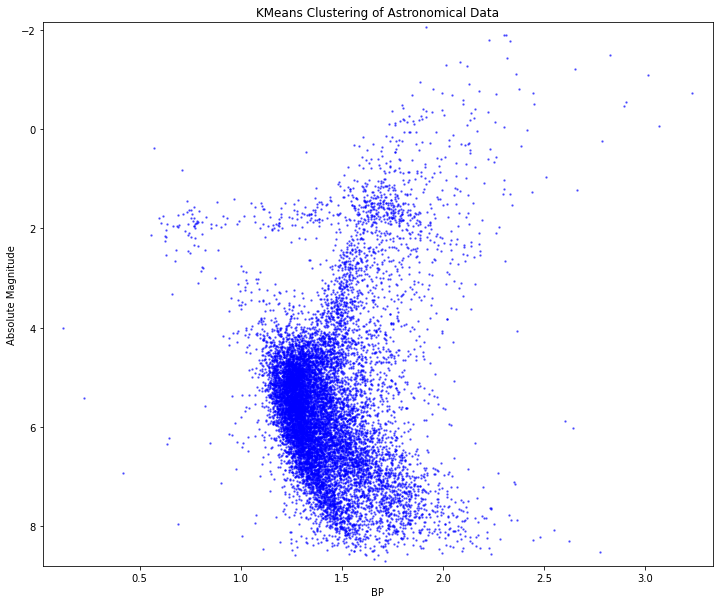

In [154]:
df_pd = df \
    .select("absolute_mag", "bp_rp") \
    .where(F.col("distance_error_ly") < 1_000) \
    .where(F.col("distance_ly") > 4000) \
    .sample(fraction=0.9, seed=42) \
    .toPandas()


plt.figure(figsize=(12, 10))
scatter = plt.scatter(df_pd["bp_rp"], df_pd["absolute_mag"], alpha=0.5, s=2, color="blue")

margin = 0.1
plt.xlim(df_pd["bp_rp"].min() - margin, df_pd["bp_rp"].max() + margin)
plt.ylim(df_pd["absolute_mag"].min() - margin, df_pd["absolute_mag"].max() + margin)
plt.gca().invert_yaxis()

plt.xlabel("BP")
plt.ylabel("Absolute Magnitude")
plt.title("KMeans Clustering of Astronomical Data")

plt.show()